<a href="https://colab.research.google.com/github/BachiLi/redner/blob/master/tutorials/batch_rendering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In deep learning or multi-view reconstruction it is common to deal with images batches. While you can always render multiple images in a loop in redner and stack them together, redner provides functionality that makes this slightly easier. Basically you can just pass in a list of scenes to the rendering functions.

In [0]:
!pip install --upgrade redner-gpu

Requirement already up-to-date: redner-gpu in /usr/local/lib/python3.6/dist-packages (0.1.22)


In [0]:
import torch
import pyredner

This time we will download the famous [Stanford bunny](https://en.wikipedia.org/wiki/Stanford_bunny) from, again, Morgan McGuire's awesome [website](https://casual-effects.com/data/):

In [0]:
import urllib
import zipfile
# wget
filedata = urllib.request.urlretrieve('https://casual-effects.com/g3d/data10/research/model/bunny/bunny.zip', 'bunny.zip')
# unzip
zip_ref = zipfile.ZipFile('bunny.zip', 'r')
zip_ref.extractall('bunny/')

In [0]:
objects = pyredner.load_obj('bunny/bunny.obj', return_objects=True)

We setup four cameras looking at the bunny:

In [0]:
camera0 = pyredner.automatic_camera_placement(objects, resolution=(512, 512))

In [0]:
print(camera0.position)
print(camera0.look_at)

tensor([-0.1490,  0.8314, -2.4995])
tensor([-0.1490,  0.8314,  0.0732])


In [0]:
camera1 = pyredner.Camera(position = camera0.look_at + torch.tensor([0.0, 0.0, 2.5]),
                         look_at = camera0.look_at,
                         up = camera0.up,
                         fov = camera0.fov,
                         resolution = camera0.resolution)
camera2 = pyredner.Camera(position = camera0.look_at + torch.tensor([2.5, 0.0, 0.0]),
                         look_at = camera0.look_at,
                         up = camera0.up,
                         fov = camera0.fov,
                         resolution = camera0.resolution)
camera3 = pyredner.Camera(position = camera0.look_at + torch.tensor([-2.5, 0.0, 0.0]),
                         look_at = camera0.look_at,
                         up = camera0.up,
                         fov = camera0.fov,
                         resolution = camera0.resolution)

Now we setup four scenes for rendering the batch:

In [0]:
scene0 = pyredner.Scene(camera = camera0, objects = objects)
scene1 = pyredner.Scene(camera = camera1, objects = objects)
scene2 = pyredner.Scene(camera = camera2, objects = objects)
scene3 = pyredner.Scene(camera = camera3, objects = objects)
scenes = [scene0, scene1, scene2, scene3]

The rendering functions in redner can take a list of scenes, which returns a batch of images. Internally it just sequentially renders the images.

In [0]:
imgs = pyredner.render_albedo(scenes)

Scene construction, time: 21.93361 s
Forward pass, time: 0.04193 s
Scene construction, time: 0.11739 s
Forward pass, time: 0.04576 s
Scene construction, time: 0.11353 s
Forward pass, time: 0.04110 s
Scene construction, time: 0.11754 s
Forward pass, time: 0.04764 s


In [0]:
print(imgs.shape) # The shape is [N, H, W, C]

torch.Size([4, 512, 512, 3])


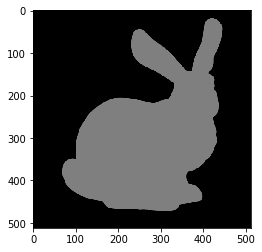

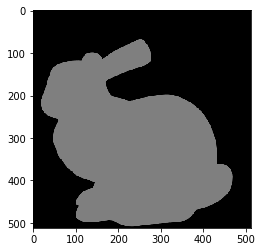

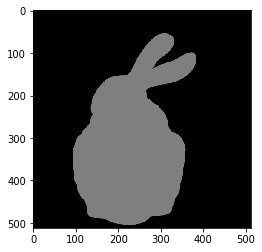

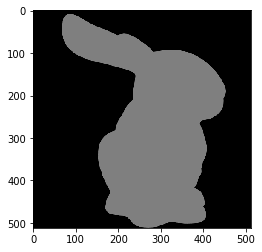

In [0]:
# Visualize imgs
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.imshow(imgs[0, :, :, :].cpu())
plt.figure()
plt.imshow(imgs[1, :, :, :].cpu())
plt.figure()
plt.imshow(imgs[2, :, :, :].cpu())
plt.figure()
plt.imshow(imgs[3, :, :, :].cpu())
plt.show()

This also works for other rendering modes. For example we can batch render in the deferred rendering mode. Batch rendering might be faster in the deferred rendering mode since we batch the lighting if the user provides the same lights for all scenes.

Scene construction, time: 0.01217 s
Forward pass, time: 0.07779 s
Scene construction, time: 0.01128 s
Forward pass, time: 0.07539 s
Scene construction, time: 0.01126 s
Forward pass, time: 0.07771 s
Scene construction, time: 0.01098 s
Forward pass, time: 0.07545 s


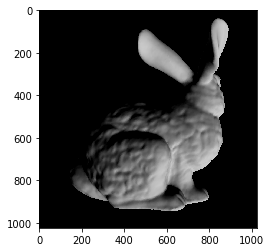

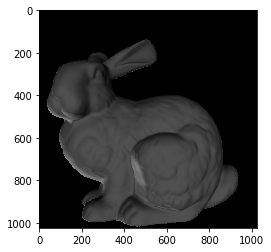

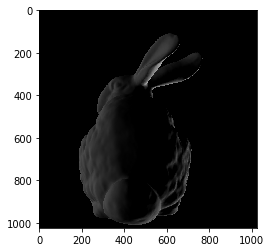

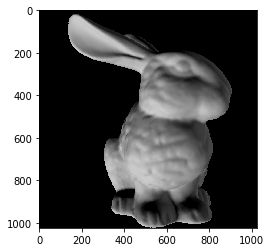

In [0]:
# lights can be a list or list of lists. The latter provides a different list of lights for each scene.
lights = [pyredner.DirectionalLight(torch.tensor([1.0, 1.0, 1.0], device = pyredner.get_device()), torch.tensor([5.0, 5.0, 5.0], device = pyredner.get_device())),
         pyredner.DirectionalLight(torch.tensor([0.0, 0.0, -1.0], device = pyredner.get_device()), torch.tensor([2.0, 2.0, 2.0], device = pyredner.get_device()))]
imgs = pyredner.render_deferred(scene = scenes, lights = lights)
plt.figure()
plt.imshow(imgs[0, :, :, :].cpu())
plt.figure()
plt.imshow(imgs[1, :, :, :].cpu())
plt.figure()
plt.imshow(imgs[2, :, :, :].cpu())
plt.figure()
plt.imshow(imgs[3, :, :, :].cpu())
plt.show()

Note that you can change the geometries, materials, and lighting arbitrariliy in batch rendering. The only parameter that needs to be the same across the batch is the output size for each scene.